In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

## Ising Model

The Ising model describes a system of spins on a lattice, where each spin can have a value of either -1 or +1. The total energy of a configuration in the Ising model is given by:

$$ E_\mu = \sum_{\langle i,j \rangle} -J \sigma_i \sigma_j $$

<p align="center">
  <img src="/images/ising_model.png" alt="drawing" width="400" align="center"/>
</p>

Here, $\sigma_i$ represents the spin value at site $i$ on the lattice, and the sum $\sum_{\langle i,j \rangle}$ is taken over pairs of nearest-neighbor spins. The parameter $J$ represents the interaction strength between adjacent spins.

## Detailed Balance Condition

To ensure that the system reaches equilibrium, we need to satisfy the detailed balance condition. The detailed balance condition states that the rate of transition between two states $\mu$ and $\nu$ should be balanced when the system is in equilibrium:

$$ p_\mu P(\mu \to \nu) = p_\nu P(\nu \to \mu) $$


In the Ising model, we can simplify this condition using the probabilities $p_\mu$ and $p_\nu$ defined earlier:

$$ \frac{p_\nu}{p_\mu} = \frac{P(\mu \to \nu)}{P(\nu \to \mu)} = e^{-\beta (E_\nu - E_\mu)} $$

<p align="center">
  <img src="/images/detailed_balance.png" alt="drawing" width="400" align="center"/>
</p>


Here, $\beta = \frac{1}{kT}$ is the inverse temperature, and $k$ is the Boltzmann constant.

## Metropolis Algorithm

The Metropolis algorithm is a Monte Carlo method used to simulate the Ising model and reach an equilibrium state. The algorithm proceeds as follows:

1. Initialize the lattice with random spin values.
2. Choose a random spin site on the lattice and flip its spin. The resulting configuration is denoted as $\nu$.
3. Calculate the energy difference between the new configuration $\nu$ and the current configuration $\mu$: $\Delta E = E_\nu - E_\mu$.
4. If $\Delta E \leq 0$, accept the new configuration $\nu$ as the current configuration with probability 1.
5. If $\Delta E > 0$, accept the new configuration $\nu$ as the current configuration with probability $e^{-\beta \Delta E}$.
6. Update the current configuration to $\nu$ or keep the current configuration as $\mu$ based on the acceptance probabilities.
7. Repeat steps 2-6 for a sufficient number of iterations or until equilibrium is reached.

By repeatedly applying the Metropolis algorithm, the system will eventually settle into an equilibrium state described by the Boltzmann distribution, where the probability of each configuration $\mu$ is given by:

$$ p_\mu = \frac{1}{Z} e^{-\beta E_\mu} $$


Here, $Z$ is the partition function defined as $Z = \sum_\mu e^{-\beta E_\mu}$, which ensures normalization of the probabilities.


In [2]:
# 150 by 150 grid
N = 150

In [3]:
init_random = np.random.random((N, N)) # generates a grid with maximum negative spins
lattice_n = np.zeros((N, N))
lattice_n[init_random > 0.75] = 1
lattice_n[init_random <= 0.75] = -1

init_random = np.random.random((N, N)) # generates a grid with maximum positive spins
lattice_p = np.zeros((N, N))
lattice_p[init_random > 0.25] = 1
lattice_p[init_random <= 0.25] = -1

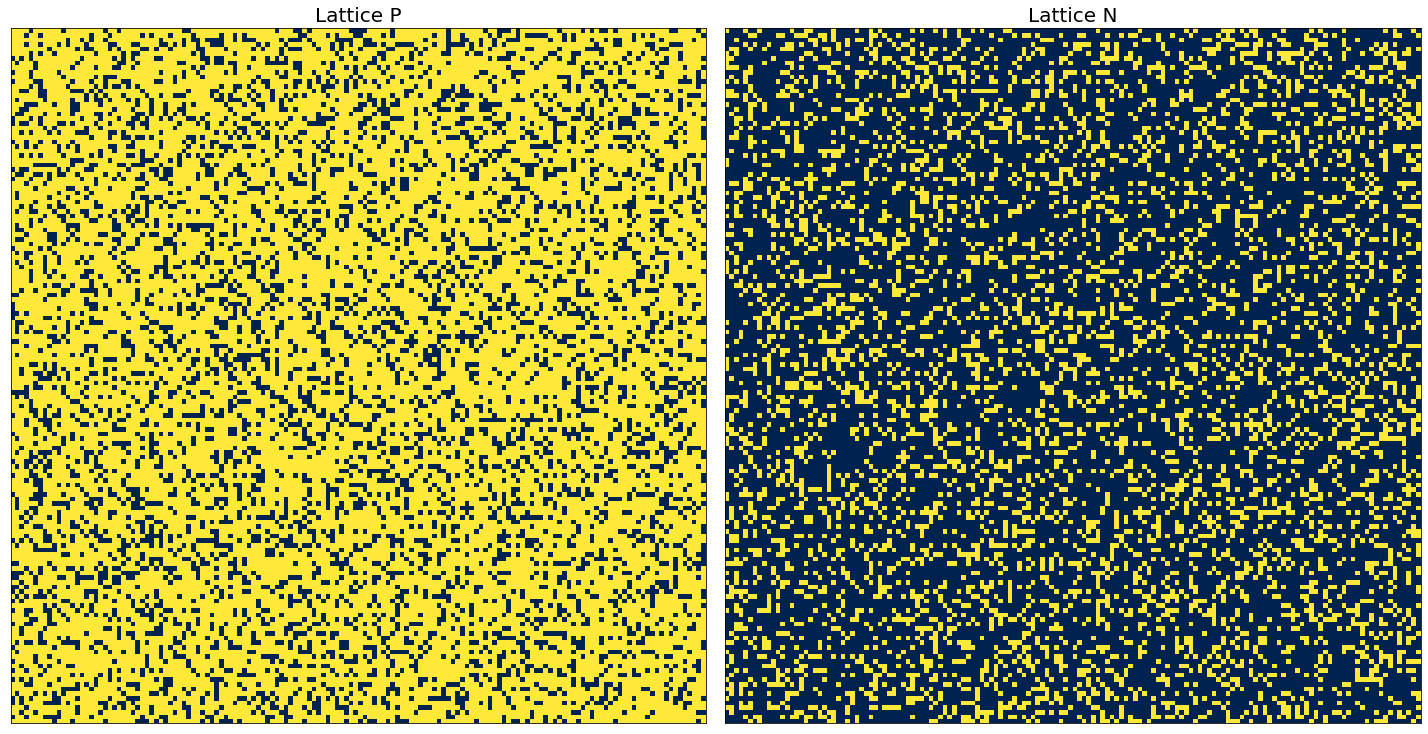

In [4]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first subplot with lattice_p
axs[0].pcolormesh(lattice_p, cmap='cividis')
axs[0].set_title('Lattice P', fontsize=20)
axs[0].set_aspect('equal')
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot the second subplot with lattice_n
axs[1].pcolormesh(lattice_n, cmap='cividis')
axs[1].set_title('Lattice N', fontsize=20)
axs[1].set_aspect('equal')
axs[1].set_xticks([])
axs[1].set_yticks([])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
def get_energy_arr(lattice):
    """
    Calculates the energy contribution from nearest neighbors for each site in the lattice.
    
    Parameters:
        lattice (numpy.ndarray): 2D lattice array.
        
    Returns:
        energy_arr (numpy.ndarray): Energy contribution array for each site.
    """
    kernel = generate_binary_structure(2, 1)
    kernel[1, 1] = False
    energy_arr = -lattice * convolve(lattice, kernel, mode='constant', cval=0.0)
    return energy_arr

def get_energy(lattice):
    """
    Calculates the total energy of the lattice.
    
    Parameters:
        lattice (numpy.ndarray): 2D lattice array.
        
    Returns:
        total_energy (float): Total energy of the lattice.
    """
    energy_arr = get_energy_arr(lattice)
    total_energy = energy_arr.sum()
    return total_energy

def get_dE_arr(lattice):
    """
    Calculates the change in energy array when flipping each site in the lattice.
    
    Parameters:
        lattice (numpy.ndarray): 2D lattice array.
        
    Returns:
        dE_arr (numpy.ndarray): Change in energy array when flipping each site.
    """
    dE_arr = -2 * get_energy_arr(lattice)
    return dE_arr

In [6]:
def metropolis(spin_arr, n_iters, BJ):
    """
    Applies the Metropolis algorithm to update the spin_arr for a given number of iterations.

    Parameters:
        spin_arr (numpy.ndarray): Initial 2D grid of spins.
        n_iters (int): Number of iterations to run the algorithm for.
        BJ (float): Temperature parameter.

    Returns:
        avg_spins (numpy.ndarray): Array of average spins over iterations.
        energies (numpy.ndarray): Array of energies over iterations.
    """
    energies = []
    avg_spins = []
    spin_arr = spin_arr.copy()

    for t in range(n_iters):
        i = np.random.randint(0, 2)
        j = np.random.randint(0, 2)
        dE = get_dE_arr(spin_arr)[i::2, j::2]
        change = (dE >= 0) * (np.random.random(dE.shape) < np.exp(-BJ * dE)) + (dE < 0)
        spin_arr[i::2, j::2][change] *= -1
        energies.append(get_energy(spin_arr))
        avg_spins.append(spin_arr.sum() / N ** 2)

    return np.array(avg_spins), np.array(energies)

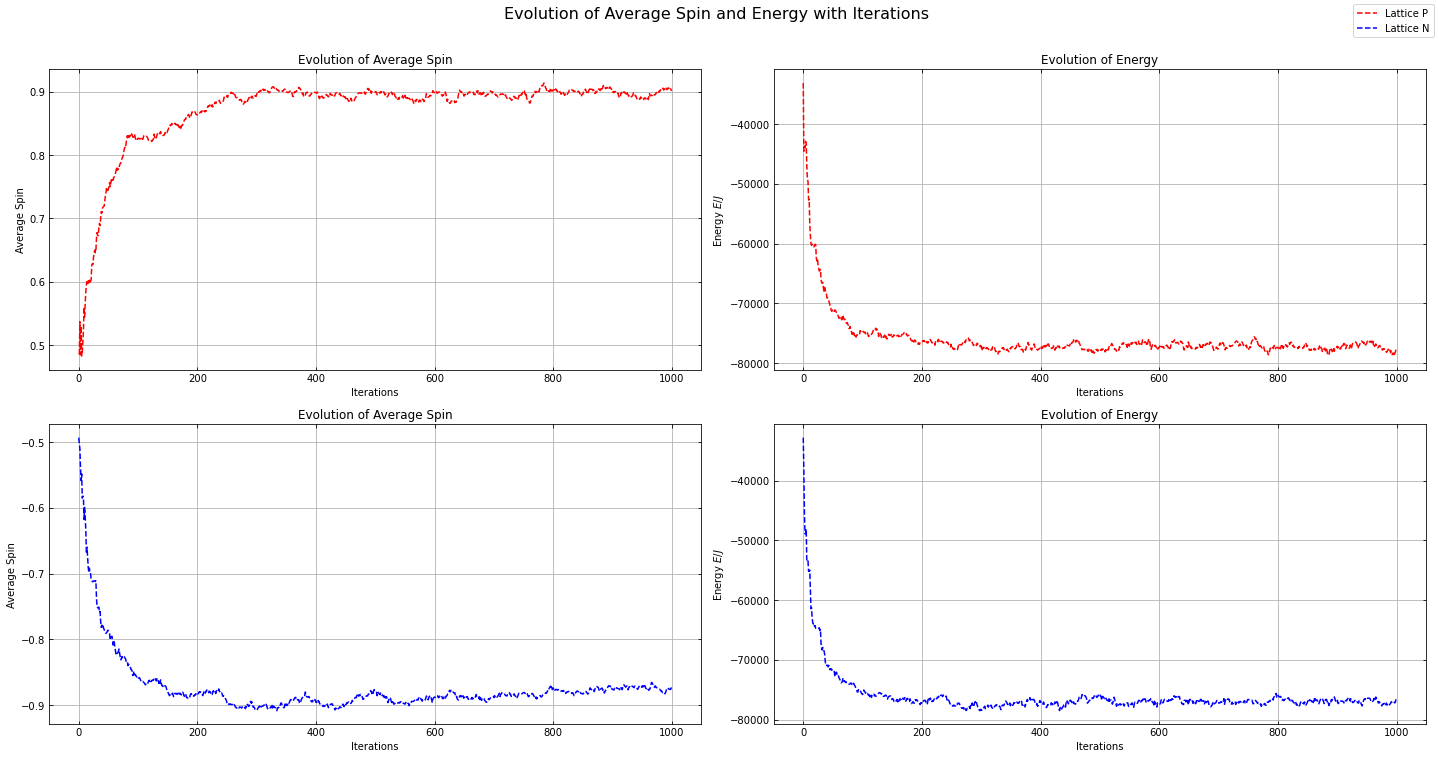

In [7]:
spins_p, energies_p = metropolis(lattice_p, 1000, 0.5)
spins_n, energies_n = metropolis(lattice_n, 1000, 0.5)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# plot the average spin and energies for lattice_p
ax = axes[0][0]
ax.plot(spins_p, '--k', c='r', label='Lattice P')
ax.set_xlabel('Iterations')
ax.set_ylabel('Average Spin')
ax.grid(True)
ax.set_title('Evolution of Average Spin')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax = axes[0][1]
ax.plot(energies_p, '--k', c='r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy $E/J$')
ax.grid(True)
ax.set_title('Evolution of Energy')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# plot the average spin and energies for lattice_n
ax = axes[1][0]
ax.plot(spins_n, '--k', c='b', label='Lattice N')
ax.set_xlabel('Iterations')
ax.set_ylabel('Average Spin')
ax.grid(True)
ax.set_title('Evolution of Average Spin')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax = axes[1][1]
ax.plot(energies_n, '--k', c='b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy $E/J$')
ax.grid(True)
ax.set_title('Evolution of Energy')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# Adjust the spacing and title
fig.tight_layout()
fig.suptitle('Evolution of Average Spin and Energy with Iterations', y=1.05, size=16)
fig.legend()

# Show the plot
plt.show()

## Heat Capacity and Susceptibility in the Ising Model

The Ising model is a mathematical model used to study the behavior of magnetic materials. By employing the Metropolis algorithm, we can simulate the Ising model and calculate various thermodynamic quantities. Two important quantities of interest are the heat capacity ($C_V$) and susceptibility ($\chi$), which provide insights into the system's behavior.

### Heat Capacity ($C_V$)

The heat capacity is a measure of how the energy of a system changes with temperature. It can be calculated using the formula:

$$C_V = σ_E^2 / T^2$$

Alternatively, in terms of the average energy, it can be expressed as:

$$C_V = (⟨(E/J)^2⟩ - ⟨E/J⟩^2) * (βJ)^2 * k^2$$

where $\sigma_E$ is the standard deviation of the energy, $⟨(\frac{E}{J})^2⟩$ is the average of the squared energy, ⟨$\frac{E}{J}$⟩ is the average energy, $\beta = \frac{1}{KT}$, J is the coupling constant, and k is Boltzmann's constant.

### Susceptibility (χ)

The susceptibility measures the system's response to an external magnetic field. It can be calculated as:

$$\chi = \frac{\sigma_m^2}{T} $$

where $\sigma_m$ is the standard deviation of the magnetization.

### Average Magnetization ($\vec{m}$) and Average Energy ($\vec{E}$)

The average magnetization ($\vec{m}$) is the average value of the magnetization over time, while the average energy ($\vec{E}$) is the average value of the energy over time.

In [8]:
def get_spin_energy(lattice, BJs):
    spins_avg = []
    energies_avg = []
    energies_std = []
    spins_std = []
    
    for BJ in BJs:
        spins, energies = metropolis(lattice, 1000, BJ)
        spins_avg.append(np.mean(spins[-400:]))
        spins_std.append(np.std(spins[-400:]))
        energies_avg.append(np.mean(energies[-400:]))
        energies_std.append(np.std(energies[-400:]))
    
    return np.array(spins_avg), np.array(spins_std), np.array(energies_avg), np.array(energies_std)

BJs = 1 / np.linspace(1, 3, 30)
spins_avg_n, spins_std_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
spins_avg_p, spins_std_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

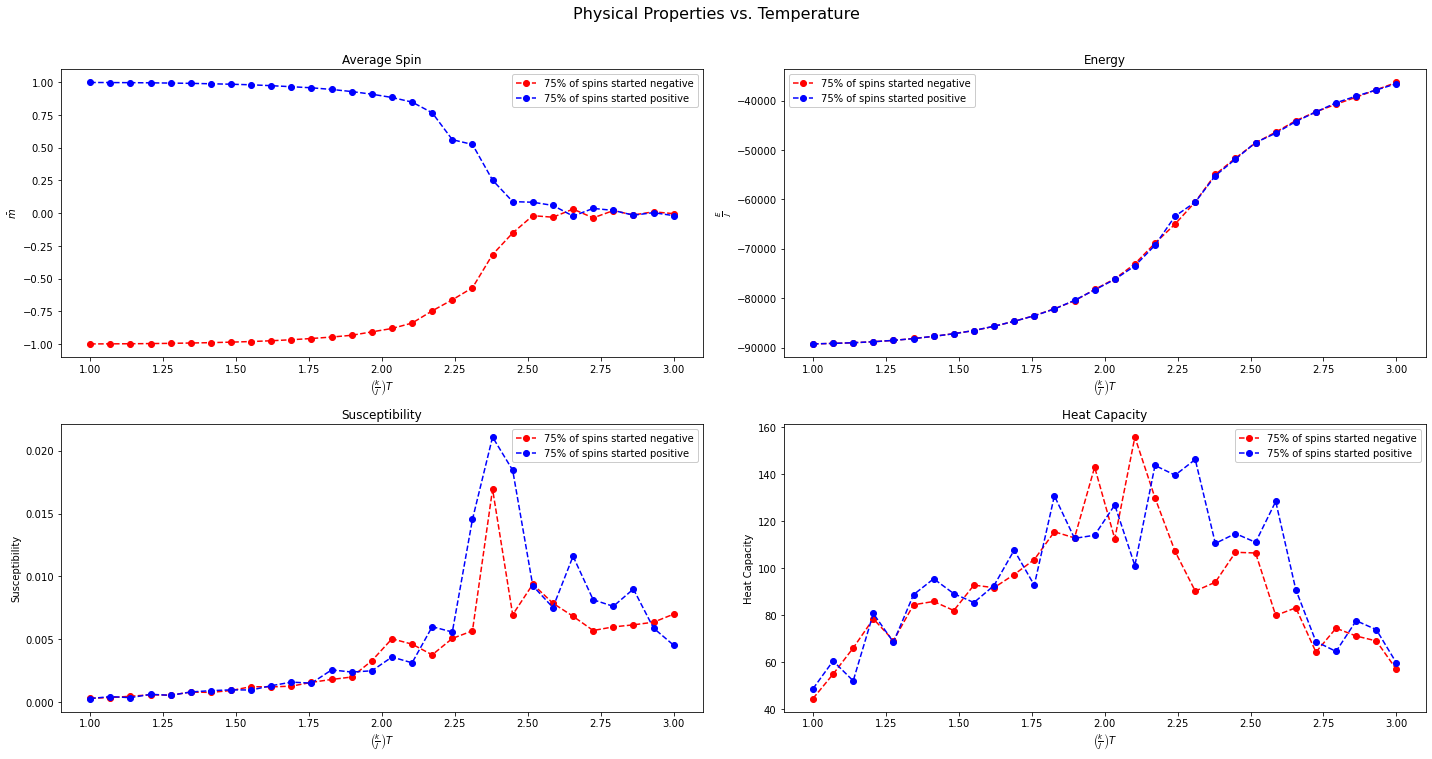

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Average spin subplot
ax_spin = axes[0, 0]
ax_spin.plot(1 / BJs, spins_avg_n, 'o--', c = 'r', label='75% of spins started negative')
ax_spin.plot(1 / BJs, spins_avg_p, 'o--', c = 'b', label='75% of spins started positive')
ax_spin.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_spin.set_ylabel(r'$\bar{m}$')
ax_spin.legend(facecolor='white', framealpha=1)
ax_spin.set_title('Average Spin')

# Energy subplot
ax_energy = axes[0, 1]
ax_energy.plot(1 / BJs, E_means_n, 'o--', c = 'r', label='75% of spins started negative')
ax_energy.plot(1 / BJs, E_means_p, 'o--', c = 'b', label='75% of spins started positive')
ax_energy.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_energy.set_ylabel(r'$\frac{E}{J}$')
ax_energy.legend(facecolor='white', framealpha=1)
ax_energy.set_title('Energy')

# Susceptibility subplot
ax_susceptibility = axes[1, 0]
ax_susceptibility.plot(1 / BJs, spins_std_n*BJs, 'o--', c = 'r', label='75% of spins started negative')
ax_susceptibility.plot(1 / BJs, spins_std_p*BJs, 'o--', c = 'b', label='75% of spins started positive')
ax_susceptibility.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_susceptibility.set_ylabel('Susceptibility')
ax_susceptibility.legend(facecolor='white', framealpha=1)
ax_susceptibility.set_title('Susceptibility')

# Heat Capacity subplot
ax_heat_capacity = axes[1, 1]
ax_heat_capacity.plot(1 / BJs, E_stds_n*BJs*BJs, 'o--', c = 'r', label='75% of spins started negative')
ax_heat_capacity.plot(1 / BJs, E_stds_p*BJs*BJs, 'o--', c = 'b', label='75% of spins started positive')
ax_heat_capacity.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax_heat_capacity.set_ylabel('Heat Capacity')
ax_heat_capacity.legend(facecolor='white', framealpha=1)
ax_heat_capacity.set_title('Heat Capacity')

# Adjust spacing and title
fig.tight_layout()
fig.suptitle('Physical Properties vs. Temperature', y=1.05, size=16)

# Show the plot
plt.show()
